In [57]:
# Step 0: basic imports and NLTK downloads
import pandas as pd
import numpy as np
import re, string
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")

# sklearn / models / metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_fscore_support
)

# Optional: xgboost
try:
    from xgboost import XGBClassifier
    has_xgb = True
except Exception:
    has_xgb = False

# NLTK setup
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
# For sentiment tasks, keep negations (not, no), they are important
for w in ('not','no','nor'):
    if w in stop_words:
        stop_words.remove(w)
lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\priyanshu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\priyanshu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\priyanshu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [58]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\priyanshu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\priyanshu\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [59]:
# Replace filename if different
FILENAME = "senti.csv"

df = pd.read_csv(FILENAME)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nLabel distribution:\n", df['Sentiment'].value_counts())
display(df.head())


Shape: (25000, 2)
Columns: ['Review', 'Sentiment']

Label distribution:
 Sentiment
1    5000
2    5000
3    5000
4    5000
5    5000
Name: count, dtype: int64


,Review,Sentiment
0,Fast shipping but this product is very cheaply...,1
1,This case takes so long to ship and it's not e...,1
2,Good for not droids. Not good for iPhones. You...,1
3,The cable was not compatible between my macboo...,1
4,The case is nice but did not have a glow light...,1


In [60]:
# drop rows with missing review or missing sentiment
df = df.dropna(subset=['Review', 'Sentiment']).reset_index(drop=True)

# drop duplicate rows (exact duplicates)
df = df.drop_duplicates().reset_index(drop=True)

print("After dropna & duplicates:", df.shape)
print("Label distribution:\n", df['Sentiment'].value_counts())


After dropna & duplicates: (24811, 2)
Label distribution:
 Sentiment
2    4990
1    4984
3    4966
4    4960
5    4911
Name: count, dtype: int64


In [61]:
def rating_to_sentiment(rating):
    if rating in [1, 2]:
        return 0   # Negative
    elif rating in [4, 5]:
        return 1   # Positive
    else:
        return None   # Neutral (3-star) → drop later

df['Sentiment'] = df['Sentiment'].apply(rating_to_sentiment)

# Drop neutral (3-star) rows
df = df.dropna(subset=['Sentiment']).reset_index(drop=True)
df['Sentiment'] = df['Sentiment'].astype(int)

print("Final Sentiment values:", df['Sentiment'].unique())
print("Value counts:\n", df['Sentiment'].value_counts())


Final Sentiment values: [0 1]
Value counts:
 Sentiment
0    9974
1    9871
Name: count, dtype: int64


In [62]:
CONTRACTIONS = {
    "don't":"do not", "doesn't":"does not", "didn't":"did not", "can't":"cannot",
    "won't":"will not", "it's":"it is", "i'm":"i am", "i've":"i have", "you're":"you are",
    "they're":"they are", "we're":"we are", "isn't":"is not", "aren't":"are not",
    "couldn't":"could not","wouldn't":"would not","shouldn't":"should not","that's":"that is"
}

def expand_contractions(text):
    text = text.lower()
    for k,v in CONTRACTIONS.items():
        text = re.sub(r"\b"+re.escape(k)+r"\b", v, text)
    return text

def clean_text(text):
    text = str(text)
    # remove HTML tags
    text = re.sub(r'<[^>]+>', ' ', text)
    # expand contractions (so "didn't" -> "did not")
    text = expand_contractions(text)
    # remove URLs and emails
    text = re.sub(r'http\S+|www\.\S+',' ', text)
    text = re.sub(r'\S+@\S+',' ', text)
    # remove non-ascii characters (drops emojis) — optional: remove to keep simpler text
    text = text.encode('ascii', 'ignore').decode('ascii')
    # remove numbers (optional)
    text = re.sub(r'\d+', ' ', text)
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # lowercase & strip
    text = text.lower().strip()
    # tokenize
    tokens = nltk.word_tokenize(text)
    # remove stopwords and very short tokens
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
    # lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)


In [63]:
# apply cleaning (progress bar optional if using tqdm)
from tqdm import tqdm
tqdm.pandas()

df['cleaned'] = df['Review'].progress_apply(clean_text)

# drop rows that became empty after cleaning
before = df.shape[0]
df = df[df['cleaned'].str.strip() != ""].reset_index(drop=True)
after = df.shape[0]
print(f"Dropped {before-after} rows empty after cleaning. New shape: {df.shape}")


100%|██████████| 19845/19845 [00:19<00:00, 1019.37it/s]


Dropped 10 rows empty after cleaning. New shape: (19835, 3)


In [64]:
df['char_count'] = df['cleaned'].apply(len)
df['word_count'] = df['cleaned'].apply(lambda x: len(x.split()))
print(df[['char_count','word_count']].describe())
print("Labels:", df['Sentiment'].value_counts(normalize=True))


         char_count    word_count
count  19835.000000  19835.000000
mean     215.490043     33.573834
std      305.913542     46.384310
min        2.000000      1.000000
25%       74.000000     12.000000
50%      124.000000     20.000000
75%      246.000000     38.000000
max     8829.000000   1406.000000
Labels: Sentiment
0    0.502798
1    0.497202
Name: proportion, dtype: float64


In [65]:
# features & labels
X_text = df['cleaned']
y = df['Sentiment'].astype(int).values

# TF-IDF settings good for sentiment tasks
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2),
                        min_df=5, max_df=0.9, sublinear_tf=True)

X = tfidf.fit_transform(X_text)
print("TF-IDF matrix shape:", X.shape)

# save vectorizer for later inference
joblib.dump(tfidf, "tfidf_vectorizer.joblib")
print("Saved TF-IDF -> tfidf_vectorizer.joblib")


TF-IDF matrix shape: (19835, 10000)
Saved TF-IDF -> tfidf_vectorizer.joblib


In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (15868, 10000) Test: (3967, 10000)


In [67]:
for name, model in models.items():
    print(f"\nTraining & evaluating: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Try to get scores for ROC AUC
    y_score = None
    try:
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)[:,1]
        elif hasattr(model, "decision_function"):
            y_score = model.decision_function(X_test)
    except Exception as e:
        print(f"[{name}] Could not compute scores for ROC AUC:", e)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    if y_score is not None and len(y_score) == len(y_test):
        roc_auc = roc_auc_score(y_test, y_score)
    else:
        roc_auc = np.nan

    prf = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    print("Accuracy: {:.4f}  |  ROC AUC: {}".format(acc, round(roc_auc,4) if not np.isnan(roc_auc) else "N/A"))
    print("Confusion Matrix:\n", cm)
    print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

    results.append({
        "model": name,
        "accuracy": acc,
        "roc_auc": float(roc_auc) if not np.isnan(roc_auc) else None,
        "precision": prf[0],
        "recall": prf[1],
        "f1": prf[2],
        "support": int((y_test==1).sum()),
        "cm": cm,
        "estimator": model
    })



Training & evaluating: LogisticRegression
Accuracy: 0.8853  |  ROC AUC: 0.9536
Confusion Matrix:
 [[1775  220]
 [ 235 1737]]

Classification Report:
               precision    recall  f1-score   support

           0     0.8831    0.8897    0.8864      1995
           1     0.8876    0.8808    0.8842      1972

    accuracy                         0.8853      3967
   macro avg     0.8853    0.8853    0.8853      3967
weighted avg     0.8853    0.8853    0.8853      3967


Training & evaluating: MultinomialNB
Accuracy: 0.8722  |  ROC AUC: 0.9448
Confusion Matrix:
 [[1729  266]
 [ 241 1731]]

Classification Report:
               precision    recall  f1-score   support

           0     0.8777    0.8667    0.8721      1995
           1     0.8668    0.8778    0.8723      1972

    accuracy                         0.8722      3967
   macro avg     0.8722    0.8722    0.8722      3967
weighted avg     0.8723    0.8722    0.8722      3967


Training & evaluating: LinearSVC
Accuracy: 0.879

Best model by accuracy: LogisticRegression


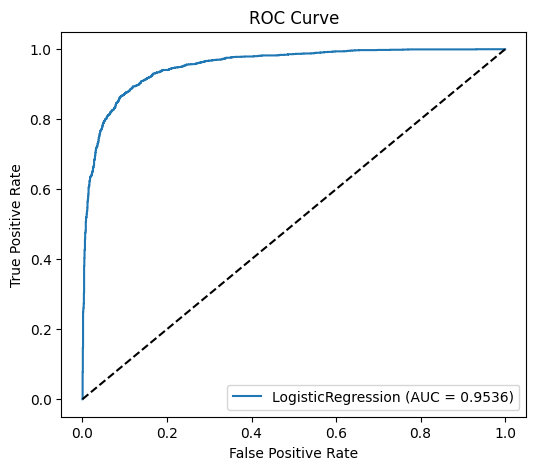

In [68]:
# pick best by accuracy
best = max(results, key=lambda r: r['accuracy'])
best_name = best['model']
best_model = best['estimator']
print("Best model by accuracy:", best_name)

# compute ROC curve if possible
try:
    if hasattr(best_model, "predict_proba"):
        y_score = best_model.predict_proba(X_test)[:,1]
    else:
        y_score = best_model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"{best_name} (AUC = {roc_auc_score(y_test, y_score):.4f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
except Exception as e:
    print("ROC curve not available for this model:", e)


In [69]:


def predict_sentiment(text):
    cleaned = clean_text(text)
    Xv = vec.transform([cleaned])
    pred = model.predict(Xv)[0]
    try:
        score = model.predict_proba(Xv)[0,1]
    except Exception:
        try:
            score = model.decision_function(Xv)[0]
        except Exception:
            score = None
    return {"prediction": int(pred), "score": float(score) if score is not None else None}

# test
print(predict_sentiment("This product is amazing, loved it!"))
print(predict_sentiment("Worst purchase ever, broke in 1 day."))


{'prediction': 1, 'score': 0.9229723811149597}
{'prediction': 0, 'score': 0.03309894725680351}


In [70]:
import joblib

# Save trained model
joblib.dump(model, "sentiment_model.joblib")

# Save TF-IDF vectorizer
joblib.dump(vectorizer, "tfidf_vectorizer.joblib")

print("✅ Model and vectorizer saved successfully!")


✅ Model and vectorizer saved successfully!
